# PROJECT -4 SENTIMENT ANALYSIS

In [1]:
from urllib import request
from urllib.request import urlopen
import nltk
from nltk import pos_tag, word_tokenize, sent_tokenize
import pandas as pd
import glob
import os
from collections import defaultdict
from collections import Counter
import re
import numpy as np
import string
from unidecode import unidecode
import pprint
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import normalize
from stop_words import get_stop_words
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

## text data

#### pre-processed ten books with chapters 

In [2]:
clean_ten = pd.read_csv('data/clean_ten_books.csv',index_col = [0])

In [3]:
raw_ten = pd.read_csv('data/raw_ten_books.csv',index_col = [0])

In [4]:
clean_book_1 = pd.read_csv('data/clean_book_1.csv',index_col = [0])
clean_book_2 = pd.read_csv('data/clean_book_2.csv',index_col = [0])
clean_book_3 = pd.read_csv('data/clean_book_3.csv',index_col = [0])
clean_book_4 = pd.read_csv('data/clean_book_4.csv',index_col = [0])
clean_book_6 = pd.read_csv('data/clean_book_6.csv',index_col = [0])
clean_book_7 = pd.read_csv('data/clean_book_7.csv',index_col = [0])
clean_book_10 = pd.read_csv('data/clean_book_10.csv',index_col = [0])
clean_book_11 = pd.read_csv('data/clean_book_11.csv',index_col = [0])
clean_book_15 = pd.read_csv('data/clean_book_15.csv',index_col = [0])
clean_book_16 = pd.read_csv('data/clean_book_16.csv',index_col = [0])
clean_book_1.head(2)

title  chapter  \
0  gentleman_burglar        1   
1  gentleman_burglar        2   

                                                text  
0  i the arrest of arsene lupin it was a strange ...  
1  ii arsene lupin in prison there is no tourist ...

In [6]:
col = clean_ten['title']
conditions = [(col.eq('gentleman_burglar')), (col.eq('arsene_lupin_vs_herlock_sholmes')),
              (col.eq('the_hollow_needle')), (col.eq('the_blonde_lady')), (col.eq('the_crystal_stopper')),
              (col.eq('the_confessions_of_arsene_lupin')),(col.eq('the_double_life_of_arsene_lupin')),
              (col.eq('the_secret_of_sarek')), (col.eq('the_secret_tombe')),
              (col.eq('the_return_of_arsene_lupin'))]
choices = ('book_01', 'book_02', 'book_03', 'book_04', 'book_06', 
           'book_07', 'book_10', 'book_11', 'book_15', 'book_16')
clean_ten['book_id'] = np.select(conditions,choices)

In [7]:
clean_ten = clean_ten[['book_id', 'title', 'chapter', 'text']]
#clean_ten

In [8]:
clean_ten = clean_ten.reset_index()
del clean_ten['index']

In [9]:
clean_ten.head()

book_id              title  chapter  \
0  book_01  gentleman_burglar        1   
1  book_01  gentleman_burglar        2   
2  book_01  gentleman_burglar        3   
3  book_01  gentleman_burglar        4   
4  book_01  gentleman_burglar        5   

                                                text  
0  i the arrest of arsene lupin it was a strange ...  
1  ii arsene lupin in prison there is no tourist ...  
2  iii the escape of arsene lupin arsene lupin ha...  
3  iv the mysterious traveller the evening before...  
4  v the queen s necklace two or three times each...

In [10]:
col = raw_ten['title']
conditions = [(col.eq('gentleman_burglar')), (col.eq('arsene_lupin_vs_herlock_sholmes')),
              (col.eq('the_hollow_needle')), (col.eq('the_blonde_lady')), (col.eq('the_crystal_stopper')),
              (col.eq('the_confessions_of_arsene_lupin')),(col.eq('the_double_life_of_arsene_lupin')),
              (col.eq('the_secret_of_sarek')), (col.eq('the_secret_tombe')),
              (col.eq('the_return_of_arsene_lupin'))]
choices = ('book_01', 'book_02', 'book_03', 'book_04', 'book_06', 
           'book_07', 'book_10', 'book_11', 'book_15', 'book_16')
raw_ten['book_id'] = np.select(conditions,choices)

In [11]:
raw_ten = raw_ten[['book_id', 'title', 'chapter', 'text']]

In [12]:
raw_ten = raw_ten.reset_index()
del raw_ten['index']

In [13]:
raw_ten.head()

book_id              title chapter  \
0  book_01  gentleman_burglar      01   
1  book_01  gentleman_burglar      02   
2  book_01  gentleman_burglar      03   
3  book_01  gentleman_burglar      04   
4  book_01  gentleman_burglar      05   

                                                text  
0  I. The Arrest of Arsène Lupin\r\n\r\n\r\nIt wa...  
1  II. Arsène Lupin in Prison\r\n\r\n\r\nThere is...  
2  III. The Escape of Arsène Lupin\r\n\r\n\r\nArs...  
3  IV. The Mysterious Traveller\r\n\r\n\r\nThe ev...  
4  V. The Queen’s Necklace\r\n\r\n\r\nTwo or thre...

In [14]:
df = raw_ten.copy()

In [15]:
lupin_dict = {k: f.groupby('chapter')['text'].apply(list).to_dict()
             for k, f in df.groupby('title')}

In [16]:
print(lupin_dict.keys())

dict_keys(['arsene_lupin_vs_herlock_sholmes', 'gentleman_burglar', 'the_blonde_lady', 'the_confessions_of_arsene_lupin', 'the_crystal_stopper', 'the_double_life_of_arsene_lupin', 'the_hollow_needle', 'the_return_of_arsene', 'the_secret_of_sarek', 'the_secret_tombe'])


In [17]:
#print(lupin_dict['the_blonde_lady'])

In [18]:
#print(lupin_dict['the_blonde_lady']['C7'])

In [21]:
analyzer = SentimentIntensityAnalyzer()
clean_ten['neg'] = clean_ten['text'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
clean_ten['neu'] = clean_ten['text'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
clean_ten['pos'] = clean_ten['text'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
clean_ten.head()

book_id              title  chapter  \
0  book_01  gentleman_burglar        1   
1  book_01  gentleman_burglar        2   
2  book_01  gentleman_burglar        3   
3  book_01  gentleman_burglar        4   
4  book_01  gentleman_burglar        5   

                                                text    neg    neu    pos  
0  i the arrest of arsene lupin it was a strange ...  0.106  0.752  0.143  
1  ii arsene lupin in prison there is no tourist ...  0.100  0.771  0.128  
2  iii the escape of arsene lupin arsene lupin ha...  0.096  0.793  0.112  
3  iv the mysterious traveller the evening before...  0.104  0.786  0.110  
4  v the queen s necklace two or three times each...  0.084  0.787  0.129

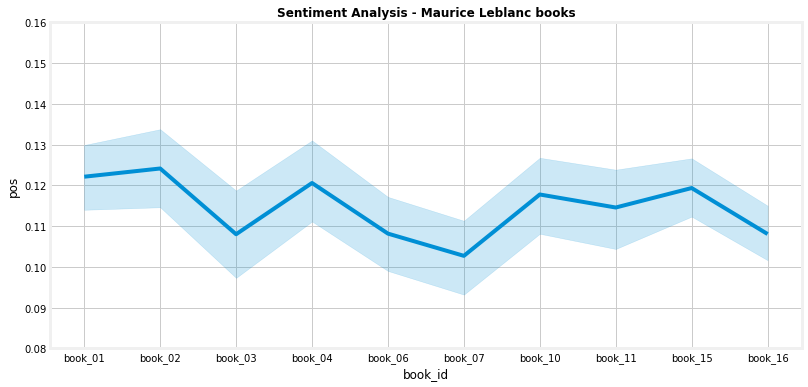

In [25]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0.08,.16)
sns.lineplot(data = clean_ten, x = 'book_id', y ='pos',ax = ax )
ax.set_facecolor("white")
#plt.grid(b=None)
plt.title('Sentiment Analysis - Maurice Leblanc books', fontsize=12, fontweight='bold')
plt.savefig('sentpos_overtime.pdf')
plt.savefig('sentpos_overtime.png')

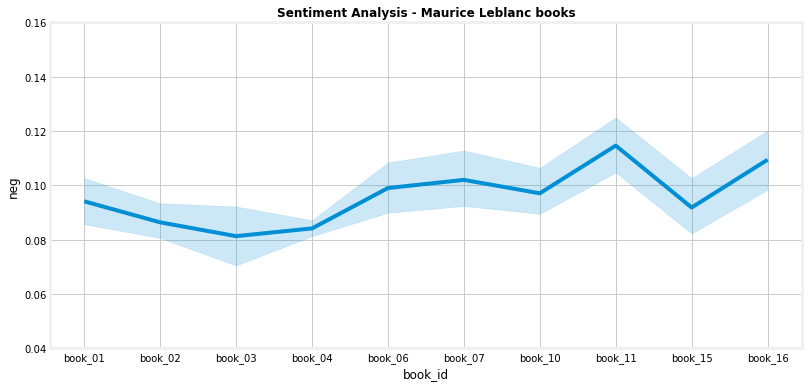

In [26]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0.04,.16)
sns.lineplot(data = clean_ten, x = 'book_id', y ='neg', ax = ax )
ax.set_facecolor("white")
plt.title('Sentiment Analysis - Maurice Leblanc books', fontsize=12, fontweight='bold')
plt.savefig('sentneg_overtime.pdf')
plt.savefig('sentneg_overtime.png')

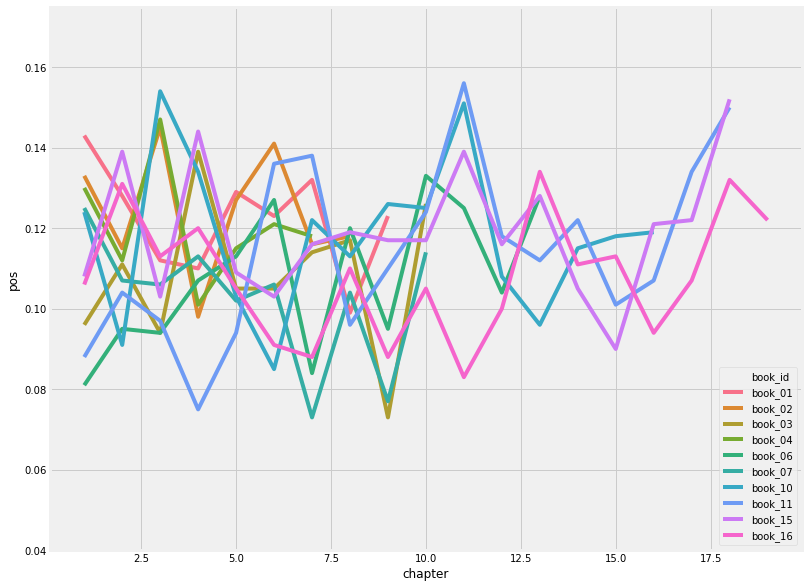

In [23]:
plt.rcParams["figure.figsize"] =(12, 10)
fig, ax = plt.subplots()
ax.set_ylim(0.04,.175)
sns.lineplot(data = clean_ten, x = 'chapter', y ='pos', hue ='book_id', ax = ax )

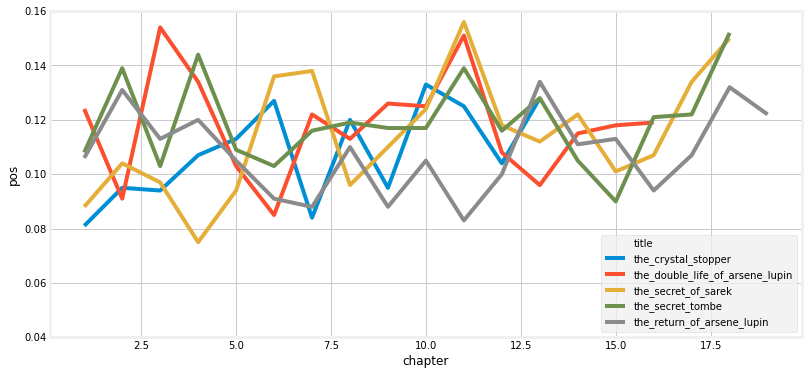

In [24]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0.04,.16)
sns.lineplot(data = clean_ten.loc[(clean_ten['book_id'].isin
                                   (['book_06','book_10','book_11','book_15','book_16']))],
                                   x = 'chapter', y ='pos', hue ='title', ax = ax )
ax.set_facecolor("white")

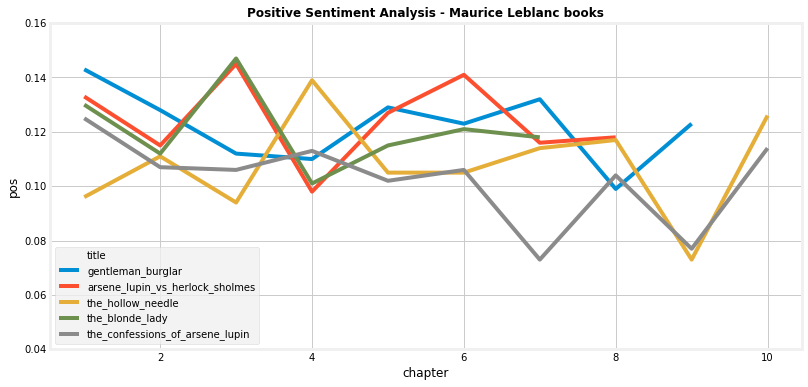

In [28]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0.04,.16)
sns.lineplot(data = clean_ten.loc[(clean_ten['book_id'].isin
                                   (['book_01','book_02','book_03','book_04','book_07']))],
                                   x = 'chapter', y ='pos', hue ='title', ax = ax )
ax.set_facecolor("white")
plt.legend(loc='lower left')
plt.title('Positive Sentiment Analysis - Maurice Leblanc books', fontsize=12, fontweight='bold')
plt.savefig('sentpos_short.png')

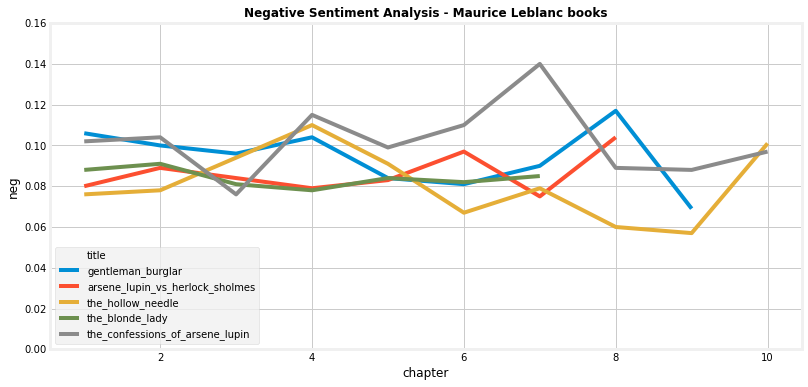

In [29]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0,.16)
sns.lineplot(data = clean_ten.loc[(clean_ten['book_id'].isin
                                   (['book_01','book_02','book_03','book_04','book_07']))],
                                   x = 'chapter', y ='neg', hue ='title', ax = ax )
ax.set_facecolor("white")
plt.legend(loc='lower left')
plt.title('Negative Sentiment Analysis - Maurice Leblanc books', fontsize=12, fontweight='bold')
plt.savefig('sentneg_short.png')

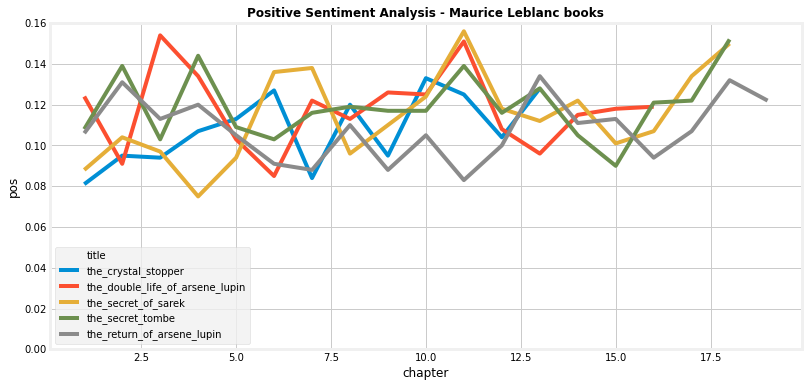

In [31]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0.0,.16)
sns.lineplot(data = clean_ten.loc[(clean_ten['book_id'].isin
                                   (['book_06','book_10','book_11','book_15','book_16']))],
                                   x = 'chapter', y ='pos', hue ='title', ax = ax )
ax.set_facecolor("white")
plt.legend(loc='lower left')
plt.title('Positive Sentiment Analysis - Maurice Leblanc books', fontsize=12, fontweight='bold')
plt.savefig('sentpos_long.png')

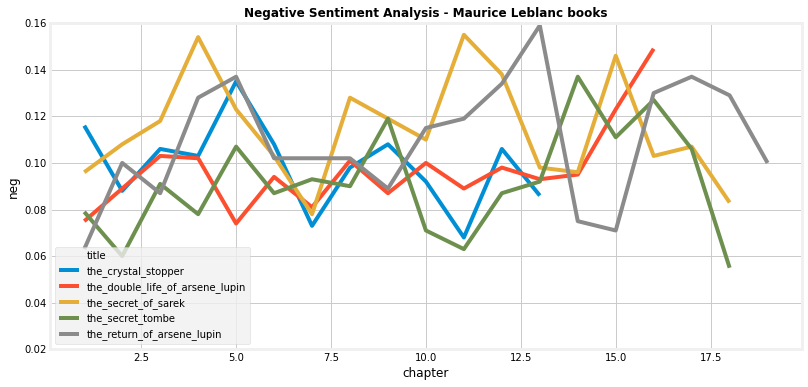

In [32]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0.02,.16)
sns.lineplot(data = clean_ten.loc[(clean_ten['book_id'].isin
                                   (['book_06','book_10','book_11','book_15','book_16']))],
                                   x = 'chapter', y ='neg', hue ='title', ax = ax )
                               
ax.set_facecolor("white")
plt.legend(loc='lower left')
plt.title('Negative Sentiment Analysis - Maurice Leblanc books', fontsize=12, fontweight='bold')
plt.savefig('sentneg_long.png')

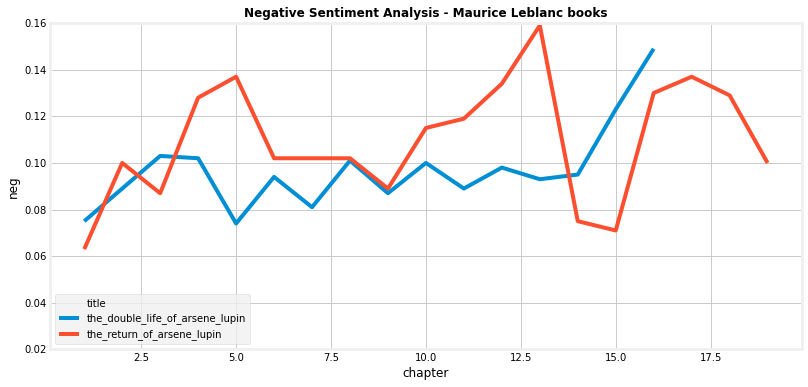

In [33]:
plt.rcParams["figure.figsize"] =(12, 6)
fig, ax = plt.subplots()
ax.set_ylim(0.02,.16)
sns.lineplot(data = clean_ten.loc[(clean_ten['book_id'].isin
                                   (['book_10','book_16']))],
                                   x = 'chapter', y ='neg', hue ='title', ax = ax )
                               
ax.set_facecolor("white")
plt.legend(loc='lower left')
plt.title('Negative Sentiment Analysis - Maurice Leblanc books', fontsize=12, fontweight='bold')
plt.savefig('sentneg_10&16.png')

In [34]:
lupin_dict_2 = {k: g["text"].tolist() for k, g in df.groupby("title")}

In [35]:
print(lupin_dict_2.keys())

dict_keys(['arsene_lupin_vs_herlock_sholmes', 'gentleman_burglar', 'the_blonde_lady', 'the_confessions_of_arsene_lupin', 'the_crystal_stopper', 'the_double_life_of_arsene_lupin', 'the_hollow_needle', 'the_return_of_arsene', 'the_secret_of_sarek', 'the_secret_tombe'])


In [36]:
analyzer = SentimentIntensityAnalyzer()

In [37]:
for book in tqdm(lupin_dict, desc = "Progress"):
    print(book)
    for chapter in tqdm(lupin_dict[book], postfix=book):
        print(' ', lupin_dict[book][chapter][0])
        text = lupin_dict[book][chapter][0].replace('\n','')
        sentence_list = sent_tokenize(text)
        sentiments = {'compound': 0.0, 'neg':0.0, 'neu':0.0, 'pos':0.0}
        
        for sentence in sentence_list:
            vs = analyzer.polarity_scores(sentence)
            sentiments['compound'] += vs['compound']
            sentiments['neg'] += vs['neg']
            sentiments['neu'] += vs['neu']
            sentiments['pos'] += vs['pos']
            
        sentiments['compound'] = sentiments['compound']/len(sentence_list)
        sentiments['neg'] = sentiments['neg']/len(sentence_list)
        sentiments['neu'] = sentiments['neu']/len(sentence_list)
        sentiments['pos'] = sentiments['pos']/len(sentence_list)
        
        lupin_dict[book][chapter] = (lupin_dict[book][chapter][0], sentiments)
    
    print()
                                                    
                                                   

arsene_lupin_vs_herlock_sholmes


  CHAPTER I.

LOTTERY TICKET NO. 514.


On the eighth day of last December, Mon. Gerbois, professor of
mathematics at the College of Versailles, while rummaging in an old
curiosity-shop, unearthed a small mahogany writing-desk which pleased
him very much on account of the multiplicity of its drawers.

"Just the thing for Suzanne's birthday present," thought he. And as he
always tried to furnish some simple pleasures for his daughter,
consistent with his modest income, he enquired the price, and, after
some keen bargaining, purchased it for sixty-five francs. As he was
giving his address to the shopkeeper, a young man, dressed with elegance
and taste, who had been exploring the stock of antiques, caught sight
of the writing-desk, and immediately enquired its price.

"It is sold," replied the shopkeeper.

"Ah! to this gentleman, I presume?"

Monsieur Gerbois bowed, and left the store, quite proud to be the
possessor of an article which had attracted the attention of a gentleman
of qualit

  CHAPTER IV.

LIGHT IN THE DARKNESS.


However well-tempered a man's character may be--and Herlock Sholmes is
one of those men over whom ill-fortune has little or no hold--there are
circumstances wherein the most courageous combatant feels the necessity
of marshaling his forces before risking the chances of a battle.

"I shall take a vacation to-day," said Sholmes.

"And what shall I do?" asked Wilson.

"You, Wilson--let me see! You can buy some underwear and linen to
replenish our wardrobe, while I take a rest."

"Very well, Sholmes, I will watch while you sleep."

Wilson uttered these words with all the importance of a sentinel on
guard at the outpost, and therefore exposed to the greatest danger. His
chest was expanded; his muscles were tense. Assuming a shrewd look, he
scrutinized, officially, the little room in which they had fixed their
abode.

"Very well, Wilson, you can watch. I shall occupy myself in the
preparation of a line of attack more appropriate to the methods of the
e

  I. The Arrest of Arsène Lupin


It was a strange ending to a voyage that had commenced in a most
auspicious manner. The transatlantic steamship ‘La Provence’ was a swift
and comfortable vessel, under the command of a most affable man. The
passengers constituted a select and delightful society. The charm of
new acquaintances and improvised amusements served to make the time pass
agreeably. We enjoyed the pleasant sensation of being separated from
the world, living, as it were, upon an unknown island, and consequently
obliged to be sociable with each other.

Have you ever stopped to consider how much originality and spontaneity
emanate from these various individuals who, on the preceding evening,
did not even know each other, and who are now, for several days,
condemned to lead a life of extreme intimacy, jointly defying the anger
of the ocean, the terrible onslaught of the waves, the violence of the
tempest and the agonizing monotony of the calm and sleepy water? Such
a life becomes a

  VII. Madame Imbert’s Safe


At three o’clock in the morning, there were still half a dozen carriages
in front of one of those small houses which form only the side of the
boulevard Berthier. The door of that house opened, and a number of
guests, male and female, emerged. The majority of them entered their
carriages and were quickly driven away, leaving behind only two men who
walked down Courcelles, where they parted, as one of them lived in that
street. The other decided to return on foot as far as the Porte-Maillot.
It was a beautiful winter’s night, clear and cold; a night on which a
brisk walk is agreeable and refreshing.

But, at the end of a few minutes, he had the disagreeable impression
that he was being followed. Turning around, he saw a man skulking amongst
the trees. He was not a coward; yet he felt it advisable to increase his
speed. Then his pursuer commenced to run; and he deemed it prudent to
draw his revolver and face him. But he had no time. The man rushed at
him and



the_blonde_lady


  CHAPTER I

NUMBER 514, SERIES 23


On the 8th of December last, M. Gerbois, professor of mathematics at
Versailles College, rummaging among the stores at a second-hand
dealer's, discovered a small mahogany writing-desk, which took his fancy
because of its many drawers.

"That's just what I want for Suzanne's birthday," he thought.

M. Gerbois' means were limited and, anxious as he was to please his
daughter, he felt it his duty to beat the dealer down. He ended by
paying sixty-five francs. As he was writing down his address, a
well-groomed and well-dressed young man, who had been hunting through
the shop in every direction, caught sight of the writing-desk and asked:

"How much for this?"

"It's sold," replied the dealer.

"Oh ... to this gentleman?"

M. Gerbois bowed and, feeling all the happier that one of his fellow-men
envied him his purchase, left the shop. But he had not taken ten steps
in the street before the young man caught him up and, raising his hat,
said, very politely:


  CHAPTER II

THE BLUE DIAMOND


In the evening of the twenty-seventh of March, old General Baron
d'Hautrec, who had been French Ambassador in Berlin under the Second
Empire, was sleeping comfortably in an easy-chair in the house which his
brother had left him six months before, at 134, Avenue Henri-Martin. His
lady companion continued to read aloud to him, while Soeur Auguste
warmed the bed and prepared the night-light.

As an exceptional case, the sister was returning to her convent that
evening, to spend the night with the Mother Superior, and, at eleven
o'clock, she said:

"I'm finished now, Mlle. Antoinette, and I'm going."

"Very well, sister."

"And don't forget that the cook is sleeping out to-night and that you
are alone in the house with the man-servant."

"You need have no fear for monsieur le baron: I shall sleep in the next
room, as arranged, and leave the door open."

The nun went away. A minute later, Charles, the man-servant, came in for
his orders. The baron had woke u

  CHAPTER III

HOLMLOCK SHEARS OPENS HOSTILITIES


"What can I get you, gentlemen?"

"Anything you please," replied Arsène Lupin, in the voice of a man who
takes no interest in his food. "Anything you please, but no meat or
wine."

The waiter walked away, with a scornful air.

I exclaimed:

"Do you mean to say that you are still a vegetarian?"

"Yes, more than ever," said Lupin.

"From taste? Conviction? Habit?"

"For reasons of health."

"And do you never break your rule?"

"Oh, yes ... when I go out to dinner, so as not to appear eccentric."

We were dining near the Gare du Nord, inside a little restaurant where
Arsène Lupin had invited me to join him. He is rather fond of
telegraphing to me, occasionally, in the morning and arranging a meeting
of this kind in some corner or other of Paris. He always arrives in the
highest spirits, rejoicing in life, unaffectedly and good-humouredly,
and always has some surprising anecdote to tell me, some memory, the
story of some adventure that I h

  Holmlock Shears and Wilson were seated on either side of the fireplace
in Shears's sitting-room. The great detective's pipe had gone out. He
knocked the ashes into the grate, re-filled his briar, lit it, gathered
the skirts of his dressing-gown around his knees, puffed away and
devoted all his attention to sending rings of smoke curling gracefully
up to the ceiling.

Wilson watched him. He watched him as a dog, rolled up on the
hearth-rug, watches its master, with wide-open eyes and unblinking lids,
eyes which have no other hope than to reflect the expected movement on
the master's part. Would Shears break silence? Would he reveal the
secret of his present dreams and admit Wilson to the realm of meditation
into which he felt that he was not allowed to enter uninvited?

Shears continued silent.

Wilson ventured upon a remark:

"Things are very quiet. There's not a single case for us to nibble at."

Shears was more and more fiercely silent; but the rings of
tobacco-smoke became more an

  "Lupin," I said, "tell me something about yourself."

"Why, what would you have me tell you? Everybody knows my life!" replied
Lupin, who lay drowsing on the sofa in my study.

"Nobody knows it!" I protested. "People know from your letters in the
newspapers that you were mixed up in this case, that you started that
case. But the part which you played in it all, the plain facts of the
story, the upshot of the mystery: these are things of which they know
nothing."

"Pooh! A heap of uninteresting twaddle!"

"What! Your present of fifty thousand francs to Nicolas Dugrival's wife!
Do you call that uninteresting? And what about the way in which you
solved the puzzle of the three pictures?"

Lupin laughed:

"Yes, that was a queer puzzle, certainly. I can suggest a title for you
if you like: what do you say to _The Sign of the Shadow_?"

"And your successes in society and with the fair sex?" I continued. "The
dashing Arsène's love-affairs!... And the clue to your good actions?
Those chapters

  Yvonne d'Origny kissed her son and told him to be good:

"You know your grandmother d'Origny is not very found of children. Now
that she has sent for you to come and see her, you must show her what a
sensible little boy you are." And, turning to the governess, "Don't
forget, Fräulein, to bring him home immediately after dinner.... Is
monsieur still in the house?"

"Yes, madame, monsieur le comte is in his study."

As soon as she was alone, Yvonne d'Origny walked to the window to catch
a glimpse of her son as he left the house. He was out in the street in a
moment, raised his head and blew her a kiss, as was his custom every
day. Then the governess took his hand with, as Yvonne remarked to her
surprise, a movement of unusual violence. Yvonne leant further out of
the window and, when the boy reached the corner of the boulevard, she
suddenly saw a man step out of a motor-car and go up to him. The man, in
whom she recognized Bernard, her husband's confidential servant, took
the child by 

  After he had been round the walls of the property, Arsène Lupin returned
to the spot from which he started. It was perfectly clear to him that
there was no breach in the walls; and the only way of entering the
extensive grounds of the Château de Maupertuis was through a little low
door, firmly bolted on the inside, or through the principal gate, which
was overlooked by the lodge.

"Very well," he said. "We must employ heroic methods."

Pushing his way into the copsewood where he had hidden his
motor-bicycle, he unwound a length of twine from under the saddle and
went to a place which he had noticed in the course of his exploration.
At this place, which was situated far from the road, on the edge of a
wood, a number of large trees, standing inside the park, overlapped the
wall.

Lupin fastened a stone to the end of the string, threw it up and caught
a thick branch, which he drew down to him and bestraddled. The branch,
in recovering its position, raised him from the ground. He climbed

  One day, at about four o'clock, as evening was drawing in, Farmer
Goussot, with his four sons, returned from a day's shooting. They were
stalwart men, all five of them, long of limb, broad-chested, with faces
tanned by sun and wind. And all five displayed, planted on an enormous
neck and shoulders, the same small head with the low forehead, thin
lips, beaked nose and hard and repellent cast of countenance. They were
feared and disliked by all around them. They were a money-grubbing,
crafty family; and their word was not to be trusted.

On reaching the old barbican-wall that surrounds the Héberville
property, the farmer opened a narrow, massive door, putting the big key
back in his pocket after his sons had passed in. And he walked behind
them, along the path that led through the orchards. Here and there stood
great trees, stripped by the autumn winds, and clumps of pines, the last
survivors of the ancient park now covered by old Goussot's farm.

One of the sons said:

"I hope mother 

  CHAPTER I. THE ARRESTS

The two boats fastened to the little pier that jutted out from the
garden lay rocking in its shadow. Here and there lighted windows showed
through the thick mist on the margins of the lake. The Enghien Casino
opposite blazed with light, though it was late in the season, the end
of September. A few stars appeared through the clouds. A light breeze
ruffled the surface of the water.

Arsene Lupin left the summer-house where he was smoking a cigar and,
bending forward at the end of the pier:

“Growler?” he asked. “Masher?... Are you there?”

A man rose from each of the boats, and one of them answered:

“Yes, governor.”

“Get ready. I hear the car coming with Gilbert and Vaucheray.”

He crossed the garden, walked round a house in process of construction,
the scaffolding of which loomed overhead, and cautiously opened the door
on the Avenue de Ceinture. He was not mistaken: a bright light flashed
round the bend and a large, open motor-car drew up, whence sprang two


  CHAPTER VI. THE DEATH-SENTENCE

Lupin’s motor-car was not only an office, a writing-room furnished
with books, stationery, pens and ink, but also a regular actor’s
dressing-room, containing a complete make-up box, a trunk filled
with every variety of wearing-apparel, another crammed with
“properties”--umbrellas, walking-sticks, scarves, eye-glasses and so
on--in short, a complete set of paraphernalia which enabled him to alter
his appearance from top to toe in the course of a drive.

The man who rang at Daubrecq the deputy’s gate, at six o-clock that
evening, was a stout, elderly gentleman, in a black frock-coat, a bowler
hat, spectacles and whiskers.

The portress took him to the front-door of the house and rang the bell.
Victoire appeared.

Lupin asked:

“Can M. Daubrecq see Dr. Vernes?”

“M. Daubrecq is in his bedroom; and it is rather late...”

“Give him my card, please.”

He wrote the words, “From Mme. Mergy,” in the margin and added:

“There, he is sure to see me.”

“But...” Vi

  CHAPTER X. EXTRA-DRY?

On one of the hills that girdle Nice with the finest scenery in the
world, between the Vallon de Saint-Silvestre and the Vallon de La
Mantega, stands a huge hotel which overlooks the town and the wonderful
Baie des Anges. A crowd flocks to it from all parts, forming a medley of
every class and nation.

On the evening of the same Saturday when Lupin, the Growler and the
Masher were plunging into Italy, Clarisse Mergy entered this hotel,
asked for a bedroom facing south and selected No. 130, on the second
floor, a room which had been vacant since that morning.

The room was separated from No. 129 by two partition-doors. As soon as
she was alone, Clarisse pulled back the curtain that concealed the first
door, noiselessly drew the bolt and put her ear to the second door:

“He is here,” she thought. “He is dressing to go to the club... as he
did yesterday.”

When her neighbour had gone, she went into the passage and, availing
herself of a moment when there was no on

  CHAPTER I

THE TRAGEDY AT THE PALACE HOTEL


Mr. Kesselbach stopped short on the threshold of the sitting-room, took
his secretary's arm and, in an anxious voice, whispered:

"Chapman, some one has been here again."

"Surely not, sir," protested the secretary. "You have just opened the
hall-door yourself; and the key never left your pocket while we were
lunching in the restaurant."

"Chapman, some one has been here again," Mr. Kesselbach repeated. He
pointed to a traveling-bag on the mantelpiece. "Look, I can prove it.
That bag was shut. It is now open."

Chapman protested.

"Are you quite sure that you shut it, sir? Besides, the bag contains
nothing but odds and ends of no value, articles of dress. . . ."

"It contains nothing else, because I took my pocket-book out before we
went down, by way of precaution. . . . But for that. . . . No, Chapman,
I tell you, some one has been here while we were at lunch."

There was a telephone on the wall. He took down the receiver:

"Hallo! . . . 

  CHAPTER V

M. LENORMAND AT WORK


On the morning of the 31st of May, all the newspapers reminded their
readers that Lupin, in a letter addressed to M. Lenormand, had announced
the escape of the messenger Jérôme for that date. And one of them summed
up the situation, as it then stood, in very able terms:

      "The horrible carnage at the Palace Hotel took place
      as far back as the 17th of April. What has been
      discovered since? Nothing.

      "There were three clues: the cigarette-case, the
      initials L and M and the parcel of clothes left behind
      in the office of the hotel. What advantage has been
      taken of these clues? None.

      "It appears that the police suspect one of the
      visitors who was staying on the first floor and who
      disappeared in a doubtful manner. Have they found him?
      Have they established his identity? No.

      "The tragedy, therefore, remains as mysterious as at
      the beginning, the gloom is impenetrable.

      "To

  CHAPTER VII

PARBURY-RIBEIRA-ALTENHEIM


The girls were playing in the garden, under the supervision of Mlle.
Charlotte, Geneviève's new assistant. Mme. Ernemont came out,
distributed some cakes among them and then went back to the room which
served as a drawing-room and parlor in one, sat down before a
writing-desk and began to arrange her papers and account-books.

Suddenly, she felt the presence of a stranger in the room. She turned
round in alarm:

"You!" she cried. "Where have you come from? How did you get in?"

"Hush!" said Prince Sernine. "Listen to me and do not let us waste a
minute: Geneviève?"

"Calling on Mrs. Kesselbach."

"When will she be here?"

"Not before an hour."

"Then I will let the brothers Doudeville come. I have an appointment
with them. How is Geneviève?"

"Very well."

"How often has she seen Pierre Leduc since I went away, ten days ago?"

"Three times; and she is to meet him to-day at Mrs. Kesselbach's, to
whom she introduced him, as you said she must. On

  CHAPTER XI

CHARLEMAGNE


"Silence!" said the stranger, sharply. "Don't use that word."

"Then what shall I call Your . . ."

"Call me nothing."

They were both silent; and this moment of respite was not one of those
which go before the struggle of two adversaries ready for the fray. The
stranger strode to and fro with the air of a master accustomed to
command and to be obeyed. Lupin stood motionless. He had abandoned his
usual provocative attitude and his sarcastic smile. He waited, gravely
and deferentially. But, down in the depths of his being, he revelled,
eagerly, madly, in the marvellous situation in which he found himself
placed: here, in his cell, he, a prisoner; he, the adventurer; he, the
swindler, the burglar; he, Arsène Lupin . . . face to face with that
demi-god of the modern world, that formidable entity, the heir of Cæsar
and of Charlemagne.

He was intoxicated for a moment with the sense of his own power. The
tears came to his eyes when he thought of his triumph. . . 



the_hollow_needle


  CHAPTER ONE

THE SHOT


Raymonde listened. The noise was repeated twice over, clearly enough to
be distinguished from the medley of vague sounds that formed the great
silence of the night and yet too faintly to enable her to tell whether
it was near or far, within the walls of the big country-house, or
outside, among the murky recesses of the park.

She rose softly. Her window was half open: she flung it back wide. The
moonlight lay over a peaceful landscape of lawns and thickets, against
which the straggling ruins of the old abbey stood out in tragic
outlines, truncated columns, mutilated arches, fragments of porches and
shreds of flying buttresses. A light breeze hovered over the face of
things, gliding noiselessly through the bare motionless branches of the
trees, but shaking the tiny budding leaves of the shrubs.

And, suddenly, she heard the same sound again. It was on the left and
on the floor below her, in the living rooms, therefore, that occupied
the left wing of the house. 

  CHAPTER SIX

AN HISTORIC SECRET


Beautrelet's resolve was soon taken: he would act alone. To inform the
police was too dangerous. Apart from the fact that he could only offer
presumptions, he dreaded the slowness of the police, their inevitable
indiscretions, the whole preliminary inquiry, during which Lupin, who
was sure to be warned, would have time to effect a retreat in good
order.

At eight o'clock the next morning, with his bundle under his arm, he
left the inn in which he was staying near Cuzion, made for the nearest
thicket, took off his workman's clothes, became once more the young
English painter that he had been and went to call on the notary at
Eguzon, the largest place in the immediate neighborhood.

He said that he liked the country and that he was thinking of taking up
his residence there, with his relations, if he could find a suitable
house.

The notary mentioned a number of properties. Beautrelet took note of
them and let fall that some one had spoken to him of the

  CHAPTER SEVEN

THE TREATISE OF THE NEEDLE


It is four o'clock in the morning. Isidore has not returned to the
Lycee Janson. He has no intention of returning before the end of the
war of extermination which he has declared against Lupin. This much he
swore to himself under his breath, while his friends drove off with
him, all faint and bruised, in a cab.

A mad oath! An absurd and illogical war! What can he do, a single,
unarmed stripling, against that phenomenon of energy and strength? On
which side is he to attack him? He is unassailable. Where to wound him?
He is invulnerable. Where to get at him? He is inaccessible.

Four o'clock in the morning. Isidore has again accepted his
schoolfellow's hospitality. Standing before the chimney in his bedroom,
with his elbows flat on the mantel-shelf and his two fists under his
chin, he stares at his image in the looking-glass. He is not crying
now, he can shed no more tears, nor fling himself about on his bed, nor
give way to despair, as he h



the_return_of_arsene


  CHAPTER I

CORALIE


It was close upon half-past six and the evening shadows were growing
denser when two soldiers reached the little space, planted with trees,
opposite the Musée Galliéra, where the Rue de Chaillot and the Rue
Pierre-Charron meet. One wore an infantryman's sky-blue great-coat; the
other, a Senegalese, those clothes of undyed wool, with baggy breeches
and a belted jacket, in which the Zouaves and the native African troops
have been dressed since the war. One of them had lost his right leg, the
other his left arm.

They walked round the open space, in the center of which stands a fine
group of Silenus figures, and stopped. The infantryman threw away his
cigarette. The Senegalese picked it up, took a few quick puffs at it,
put it out by squeezing it between his fore-finger and thumb and stuffed
it into his pocket. All this without a word.

Almost at the same time two more soldiers came out of the Rue Galliéra.
It would have been impossible to say to what branch they be

  CHAPTER XVII

SIMÉON GIVES BATTLE


It took them some time to loosen Ya-Bon's grip. Even in death the
Senegalese did not let go his prey; and his fingers, hard as iron and
armed with nails piercing as a tiger's claws, dug into the neck of the
enemy, who lay gurgling, deprived of consciousness and strength.

Don Luis caught sight of Siméon's revolver on the cobbles of the yard:

"It was lucky for you, you old ruffian," he said, in a low voice, "that
Ya-Bon did not have time to squeeze the breath out of you before you
fired that shot. But I wouldn't chortle overmuch, if I were you. He
might perhaps have spared you, whereas, now that Ya-Bon's dead, you can
write to your family and book your seat below. _De profundis_,
Diodokis!" And, giving way to his grief, he added, "Poor Ya-Bon! He
saved me from a horrible death one day in Africa . . . and to-day he
dies by my orders, so to speak. My poor Ya-Bon!"

Assisted by Patrice, he carried the negro's corpse into the little
bedroom next to the

  CHAPTER I

THE DESERTED CABIN


Into the picturesque village of Le Faouet, situated in the very heart of
Brittany, there drove one morning in the month of May a lady whose
spreading grey cloak and the thick veil that covered her face failed to
hide her remarkable beauty and perfect grace of figure.

The lady took a hurried lunch at the principal inn. Then, at about
half-past eleven, she begged the proprietor to look after her bag for
her, asked for a few particulars about the neighbourhood and walked
through the village into the open country.

The road almost immediately branched into two, of which one led to
Quimper and the other to Quimperlé. Selecting the latter, she went down
into the hollow of a valley, climbed up again and saw on her right, at
the corner of another road, a sign-post bearing the inscription,
"Locriff, 3 kilometers."

"This is the place," she said to herself.

Nevertheless, after casting a glance around her, she was surprised not
to find what she was looking for 

  CHAPTER III

VORSKI'S SON


Véronique smiled as she sat to starboard on a packing-case, with her
face turned towards Honorine. Her smile was anxious still and undefined,
full of reticence and flickering as a sunbeam that tries to pierce the
last clouds of the storm; but it was nevertheless a happy smile.

And happiness seemed the right expression for that wonderful face,
stamped with dignity and with that particular modesty which gives to
some women, whether stricken by excessive misfortune or preserved by
love, the habit of gravity, combined with an absence of all feminine
affectation.

Her black hair, touched with grey at the temples, was knotted very low
down on the neck. She had the dead-white complexion of a southerner and
very light blue eyes, of which the white seemed almost of the same
colour, pale as a winter sky. She was tall, with broad shoulders and a
well-shaped bust.

Her musical and somewhat masculine voice became light and cheerful when
she spoke of the son whom she h

  CHAPTER IV

THE POOR PEOPLE OF SAREK


Honorine's wound was deep but did not seem likely to prove fatal. When
Véronique had dressed it and moved Marie Le Goff's body to the room
filled with books and furnished like a study in which her father was
lying, she closed M. d'Hergemont's eyes, covered him with a sheet and
knelt down to pray. But the words of prayer would not come to her lips
and her mind was incapable of dwelling on a single thought. She felt
stunned by the repeated blows of misfortune. She sat down in a chair,
holding her head in her hands. Thus she remained for nearly an hour,
while Honorine slept a feverish sleep.

With all her strength she rejected her son's image, even as she had
always rejected Vorski's. But the two images became mingled together,
whirling around her and dancing before her eyes like those lights which,
when we close our eyelids tightly, pass and pass again and multiply and
blend into one. And it was always one and the same face, cruel,
sardonic, hideo

  CHAPTER X

THE ESCAPE


Shuddering, uncertain how to act next, Véronique listened till she no
longer heard the sound of his footsteps. What should she do? The murder
of Stéphane had for a moment turned her thoughts from François; but she
now once more fell a prey to anguish. What had become of her son? Should
she go to him at the Priory and defend him against the dangers that
threatened him?

"Come, come," she said, "I'm losing my head . . . . Let me think things
out . . . . A few hours ago, François was speaking to me through the
wall of his prison . . . for it was certainly he then, it was certainly
François who yesterday took my hand and covered it with his kisses
. . . . A mother cannot be deceived; and I was quivering with love and
tenderness . . . . But since . . . since this morning has he not left
his prison?"

She stopped to think and then said, slowly:

"That's it . . . that's what happened . . . . Stéphane and I were
discovered below, on the floor underneath. The alarm was

  CHAPTER I

THE CHÂTEAU DE ROBOREY


Under a sky heavy with stars and faintly brighter for a low-hanging
sickle moon, the gipsy caravan slept on the turf by the roadside, its
shutters closed, its shafts stretched out like arms. In the shadow of
the ditch nearby a stertorous horse was snoring.

Far away, above the black crest of the hills, a bright streak of sky
announced the coming of the dawn. A church clock struck four. Here and
there a bird awoke and began to sing. The air was soft and warm.

Abruptly, from the interior of the caravan, a woman's voice cried:

"Saint-Quentin! Saint-Quentin!"

A head was thrust out of the little window which looked out over the
box under the projecting roof.

"A nice thing this! I thought as much! The rascal has decamped in the
night. The little beast! Nice discipline this is!"

Other voices joined in the grumbling. Two or three minutes passed,
then the door in the back of the caravan opened and a shadowy figure
descended the five steps of the ladder

  CHAPTER VI

ON THE ROAD


Every day, at the easy walk or slack trot of One-eyed Magpie, Dorothy's
Circus moved on. In the afternoon they gave their performance; after it
they strolled about those old towns of France, the picturesque charm
of which appealed so strongly to the young girl. Domfront, Mortain,
Avranches, Fougères, Vitré, feudal cities, girdled in places by their
fortifications, or bristling with their ancient keeps.... Dorothy
visited them with all the emotion of a creature who understands the
past and evokes it with a passionate enthusiasm.

She visited them alone, even as she walked alone along the high roads,
with so manifest a desire to keep to herself that the others, while
watching her with anxious eyes and silently begging for a glance from
their little mother, did not speak a word to her.

That lasted a week, a very dull week for the children. The pale
Saint-Quentin walked at the head of One-eyed Magpie as he would have
walked at the head of a horse drawing a hear

  CHAPTER XVI

THE LAST QUARTER OF A MINUTE


Dorothy did not turn round. She was a prisoner.

"I made no mistake," she thought. "They are the masters of the field of
battle. But what has become of the others?"

On her right opened the entrance to the staircase which ascended the
tower. Perhaps she might have fled up it and availed herself once more
of the rope-ladder? But what use would it be? Did not the kidnaping of
Montfaucon oblige her to fight to the end, in spite of the hopelessness
of the conflict? She must throw herself into the arena, among the
ferocious beasts.

She went on. Though alone and without friends, she found herself quite
cool. As she went, she let the little ball of paper roll down her
skirt. It rolled along the floor and was lost among the pebbles and
dust which covered it.

As she came to the end of the vault, two arms shot out and two men
covered her with their revolvers.

"Don't move!"

She shrugged her shoulders.

One of them repeated harshly:

"Don't move, o

In [38]:
compound_sentiments = [lupin_dict[book][chapter][1]['compound'] 
                       for book in lupin_dict 
                       for chapter in lupin_dict[book]]

In [39]:
chap = 0
for book in lupin_dict:
    print(book)
    book_chap = 1
    for chapter in lupin_dict[book]:
        print('  Chapter', book_chap, '_', lupin_dict[book][chapter][0])
        print('         ', compound_sentiments[chap])
        book_chap += 1
        chap += 1
    print()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

